In [306]:
import os
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [241]:
target_dict = {
    0: "Not real disaster",
    1: "Real disaster"
}

no_real_disater = 0
real_disaster = 1

no_real_disaster_label = "no_real_disaster"
real_disaster_label = "real_disaster"

original_columns = ["id", "keyword", "location", "text", "target"]

stop_words = stopwords.words('english')

### Data folders

In [3]:
data_folder = "data"

train_file = os.path.join(data_folder, "train.csv")
test_file = os.path.join(data_folder, "test.csv")

### Data analysis

In [4]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# Adding target labels
train_df.loc[:, "target_label"] = train_df["target"].apply(lambda x: target_dict[x])

In [5]:
print(f"Train size: {train_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (7613, 6)
Test size: (3263, 4)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7552 non-null   object
 2   location      5080 non-null   object
 3   text          7613 non-null   object
 4   target        7613 non-null   int64 
 5   target_label  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


In [7]:
train_df.head()

,id,keyword,location,text,target,target_label
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Real disaster
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Real disaster
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Real disaster
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Real disaster
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster


#### NaNs vs NO NaNs by column

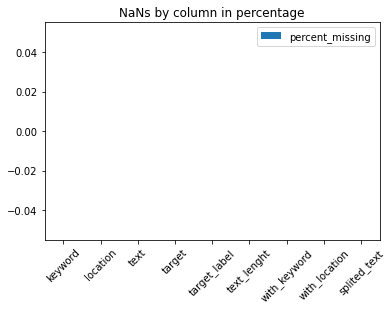

In [310]:
percent_missing = train_df.isnull().sum() * 100 / train_df.shape[0]
missing_value_df = pd.DataFrame({"percent_missing": percent_missing})

missing_value_df.sort_values(by="percent_missing", ascending=False).plot(
    kind="bar", title="NaNs by column in percentage", rot=45)

# sns.barplot(y="percent_missing",data=missing_value_df, palette='PRGn')

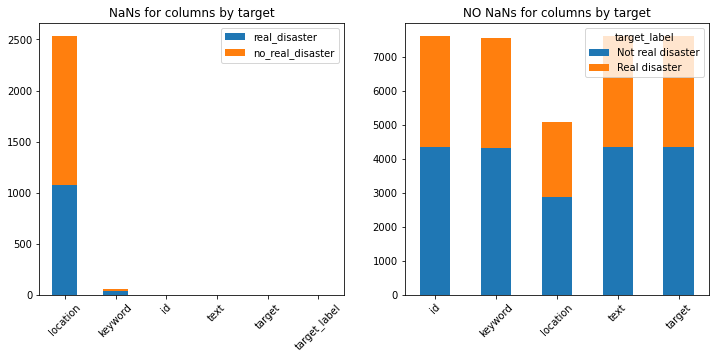

In [9]:
no_nan_df = train_df.groupby("target_label").count().transpose()

cond_disaster = train_df.target == real_disaster
nan_df = pd.concat([train_df[cond_disaster].isnull().sum(),
                    train_df[~cond_disaster].isnull().sum()], axis=1)
nan_df.columns = [real_disaster_label, no_real_disaster_label]
nan_df.sort_values(by=[real_disaster_label], ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 5))

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

nan_df.plot(kind="bar", stacked=True, title="NaNs for columns by target", ax=ax1, rot=45)
no_nan_df.plot(kind="bar", stacked=True, title="NO NaNs for columns by target", ax=ax2, rot=45)

#### Keyword

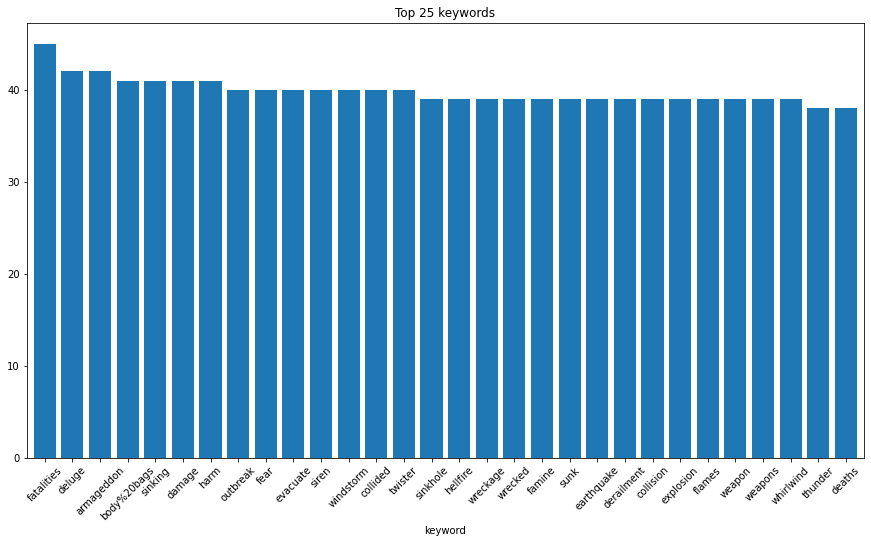

In [10]:
train_df.groupby("keyword").size().sort_values(ascending=False)[:30].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 keywords", rot=45)

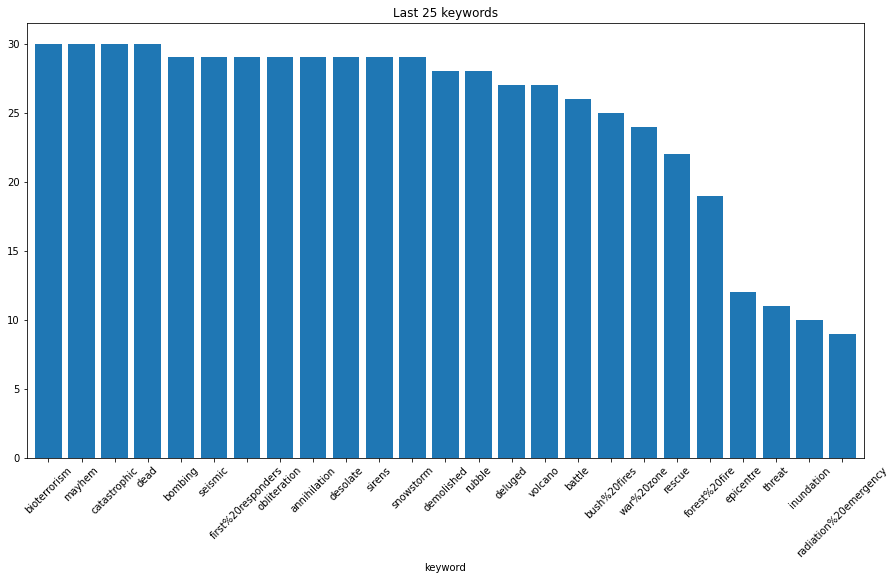

In [11]:
train_df.groupby("keyword").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 keywords", rot=45)

#### Location

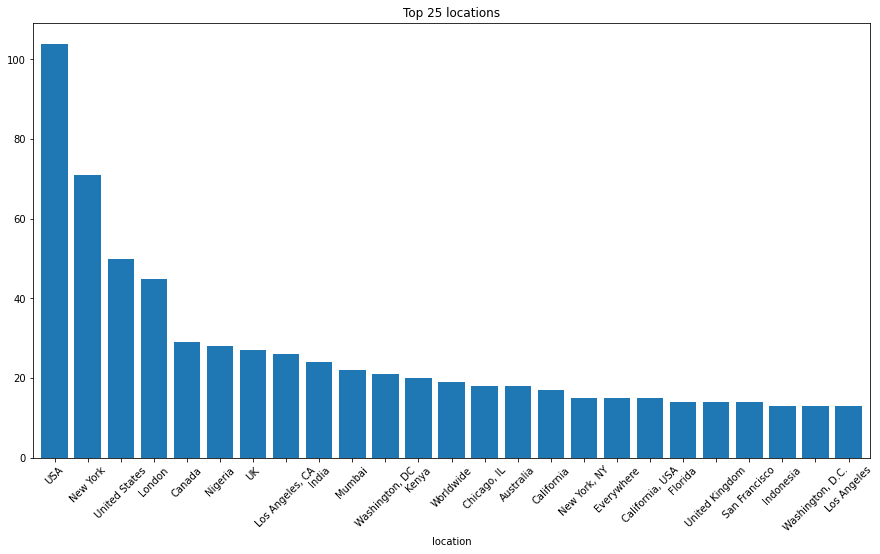

In [12]:
train_df.groupby("location").size().sort_values(ascending=False)[:25].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 locations", rot=45)

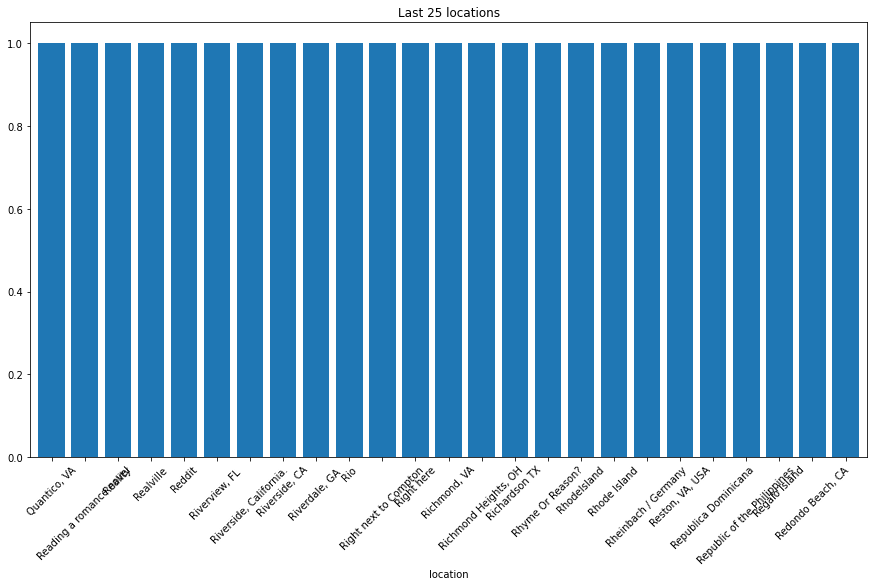

In [13]:
train_df.groupby("location").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 locations", rot=45)

#### Target

(-1.25, 1.25, -1.25, 1.25)

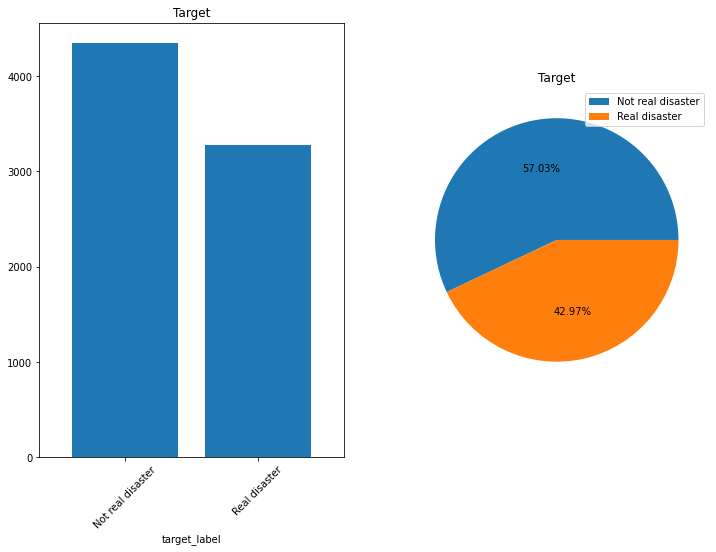

In [14]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train_df.groupby("target_label").size().sort_values(ascending=False).plot(
    kind="bar", width=0.8, title="Target", ax=ax1, rot=45)

train_df.groupby("target_label").size().sort_values(ascending=False).plot(
    kind="pie", title="Target", ax=ax2, legend=True, autopct="%.2f%%", labels=None)

ax2.axis("off")

### Text

Choose randomly 5 tweets for visualize text content

In [125]:
for tweet, keyword, label in train_df[["text", "keyword", "target_label"]].sample(n=5).values:
    print(f"{keyword}\n{tweet}\n{label}\n")

refugees
@KristinDavis @UN @Refugees Thank you @UN and @Refugees for helping so many people in need all over the world.... https://t.co/yPvJgzqqqB Û_
Not real disaster

fatalities
Govt allocating 1.3 bn for flood action: Issue takes centre stage after fatalities in Veneto http://t.co/w3esX6Ud8t
Real disaster

collided
Can't watch PVRIS I'm so sad bc it collided with another set
Real disaster

suicide%20bomb
recap/ Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/6jzCEdaYRG
Real disaster

crushed
Crushed it! https://t.co/EWnUnp8Hdo
Not real disaster



In [15]:
# Adding new feature: text_lenght
train_df.loc[:, "text_lenght"] = train_df.text.apply(len)

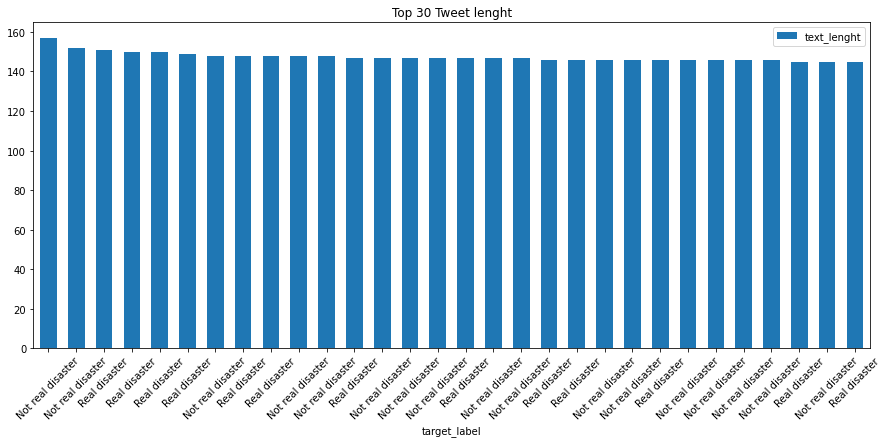

In [88]:
top_len_df = train_df[["text_lenght", "target", "target_label"]].sort_values(
    by="text_lenght", ascending=False).head(30).reset_index(drop=True)
last_len_df = train_df[["text_lenght", "target", "target_label"]].sort_values(
    by="text_lenght", ascending=False).tail(30).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 6))
top_len_df.plot(kind="bar", y="text_lenght", x="target_label", width=0.6, 
                ax=ax, title="Top 30 Tweet lenght", rot=45)

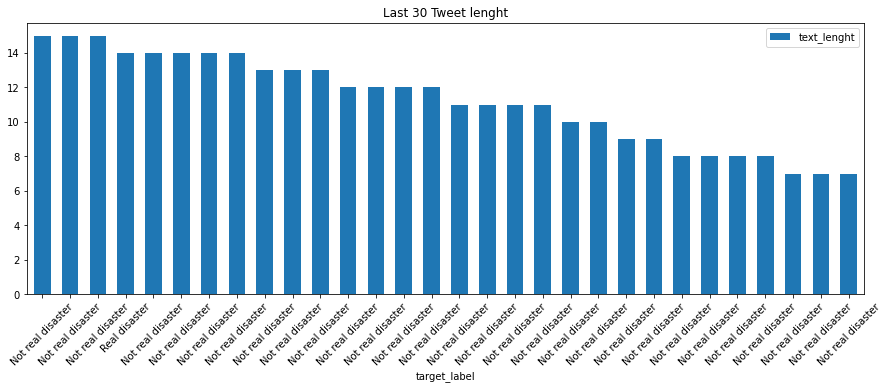

In [90]:
fig, ax = plt.subplots(figsize=(15, 5))
last_len_df.plot(kind="bar", y="text_lenght", x="target_label", width=0.6, 
                ax=ax, title="Last 30 Tweet lenght", rot=45)

In [302]:
def generate_word_frequences_dict(text_list, stop_words):
    # Filter stop words and remove puntuation
    word_list = [word for text in text_list for word in text if word.isalpha() and word not in stop_words]
    return pd.Series(word_list).value_counts().to_dict()

def generate_word_cloud(text_list, title, stop_words=stop_words):
    frequences_dict = generate_word_frequences_dict(text_list, stop_words)
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(20, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

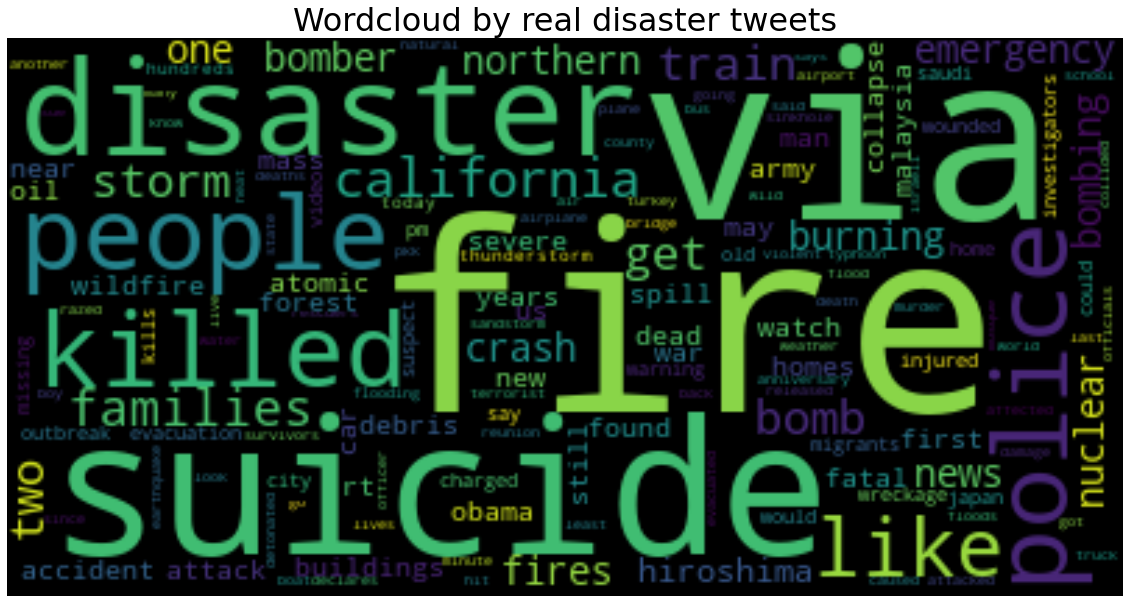

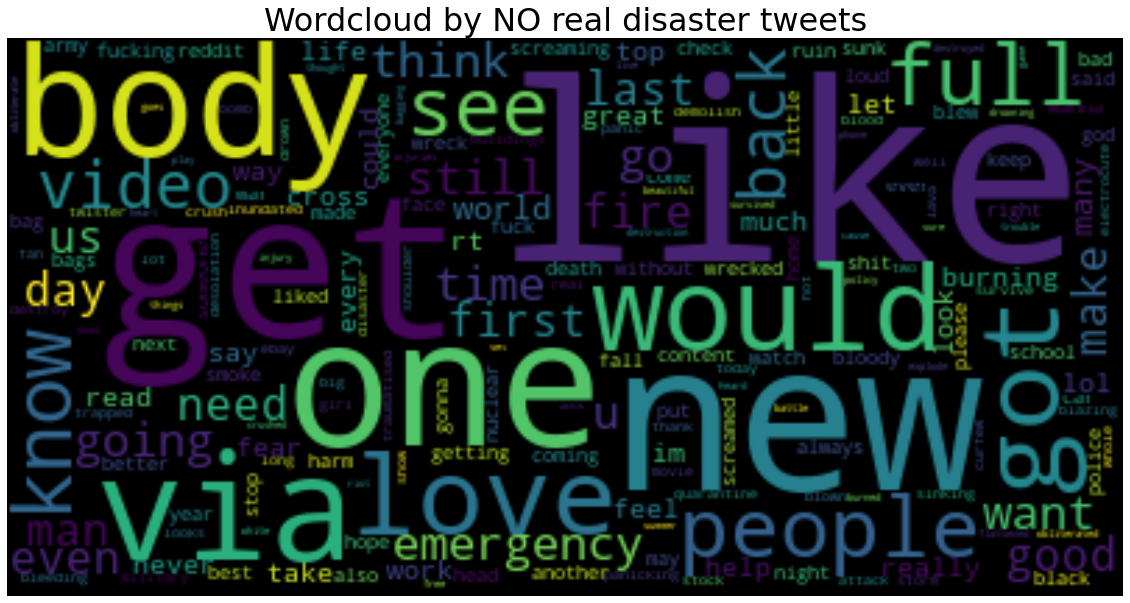

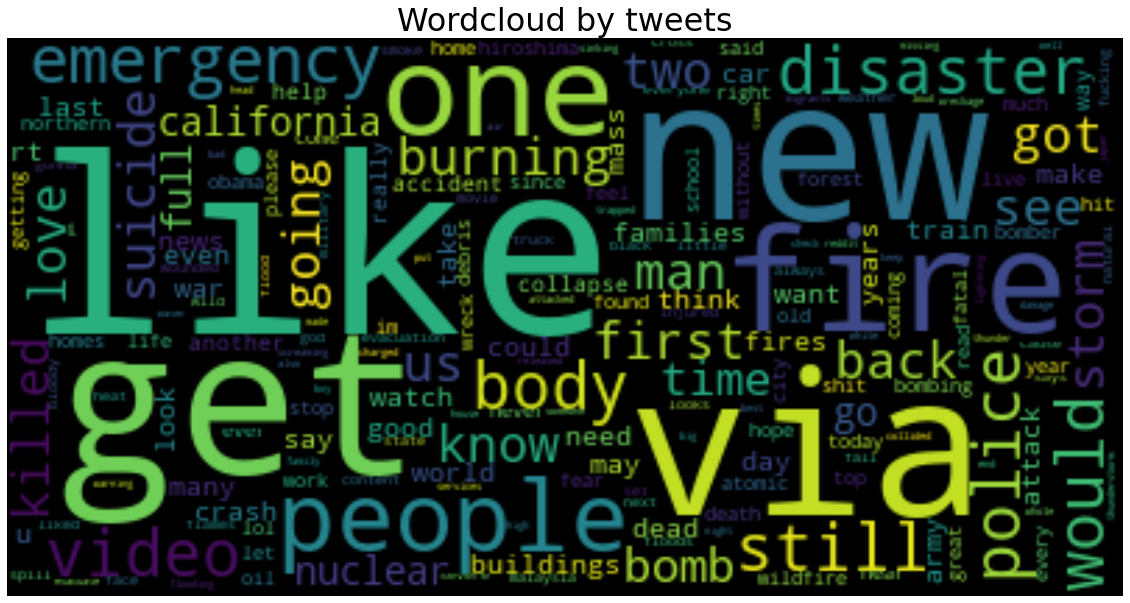

In [304]:
generate_word_cloud(train_df[cond]["splited_text"].values.tolist(), "Wordcloud by real disaster tweets")
generate_word_cloud(train_df[~cond]["splited_text"].values.tolist(), "Wordcloud by NO real disaster tweets")
generate_word_cloud(train_df["splited_text"].values.tolist(), "Wordcloud by tweets")

### Data cleaning and feature engineering

Text and target columns are ok for now. But we remove id column because is not useful.

In [94]:
train_df.drop("id", axis=1, inplace=True)

In [96]:
train_df.head()

,keyword,location,text,target,target_label,text_lenght
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Real disaster,38
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Real disaster,133
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88


Replace NaN values from keyword and location columns by empty string ("")

In [113]:
train_df.loc[:, ["keyword", "location"]] = train_df[["keyword", "location"]].fillna("")

Create new features based on keyword and location (and previous text_lenght).

In [115]:
train_df.loc[:, "with_keyword"] = train_df["keyword"].apply(bool)
train_df.loc[:, "with_location"] = train_df["location"].apply(bool)

train_df.head()

,keyword,location,text,target,target_label,text_lenght,with_keyword,with_location
0,,,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69,False,False
1,,,Forest fire near La Ronge Sask. Canada,1,Real disaster,38,False,False
2,,,All residents asked to 'shelter in place' are ...,1,Real disaster,133,False,False
3,,,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65,False,False
4,,,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88,False,False


### Analyze and clean tweets

NLTK data url: https://github.com/nltk/nltk_data

Convert tweets to sentences

In [209]:
def text_cleaning(text, stop_words):
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    # Stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    
    return stemmed

In [214]:
stop_words = stopwords.words("english")
train_df["text"].apply(text_cleaning, args=(stop_words,))

0       [our, deed, reason, earthquak, may, allah, for...
1            [forest, fire, near, La, rong, sask, canada]
2       [all, resid, ask, place, notifi, offic, No, ev...
3       [peopl, receiv, wildfir, evacu, order, califor...
4       [just, got, sent, photo, rubi, alaska, smoke, ...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [thetawniest, the, control, wild, fire, califo...
7610                      [utc, S, volcano, hawaii, http]
7611    [polic, investig, collid, car, littl, portug, ...
7612    [the, latest, more, home, raze, northern, cali...
Name: text, Length: 7613, dtype: object